In [1]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using FFTW
using Plots
using Colors
Threads.nthreads()


(process:18768): GLib-GIO-WARNING **: 09:05:25.125: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_16.5.1.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


4

In [20]:
function hamiltonian_2D(xmin, xmax, ymin, ymax, Œîx, Œîx¬≤, Œîy, Œîy¬≤, N, N¬≤, V, m, M, ƒß)
    # BLOC EXTRA-DIAGONAL
    J = -ƒß^2*  1/(2*M*Œîy¬≤)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*Œîx¬≤)+1/(M*Œîy¬≤))*ones(Float64,N);  # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*Œîx¬≤)*ones(Float64,N-1); # vecteur de la sur- et sous-diagonale remplies de 1

    T = -ƒß^2*  SymTridiagonal(diag, extra_diag);  # matrice des blocs diagonaux, qui est tridiagonale sym√©trique

    # assemblage du laplacien
    Œõ = spzeros(N¬≤,N¬≤);
    @views for i in 1:N
        Œõ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Œõ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs extradiag sup√©rieurs
        Œõ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inf√©rieurs
    end

    V = Diagonal(reshape(V,N¬≤)); # a priori inutile de convertir en sparse avant

    H = Œõ+V;
    H,Œõ,V # op√©rateurs (matrices de taille N¬≤√óN¬≤)
end


function hamiltonian_1D(dmin, dmax, Œîd¬≤, N, V, m, ƒß)
    Œõ = -ƒß^2*    1/(Œîd¬≤*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = sparse(Diagonal(V)); # V_fun.(LinRange(xmin,xmax,N)) pour cr√©er l'argument
    H = Œõ + V; 
    H,Œõ,V
end

hamiltonian_1D (generic function with 1 method)

### D√©finition du probl√®me et de ses param√®tres
On met le hamiltonien original

\begin{equation}
 -\frac{1}{2m} \frac{\partial^2}{\partial x^2} - \frac{1}{2M} \frac{\partial^2}{\partial y^2} + V(x,y)
\end{equation}

sous la forme 

\begin{equation}
    H = V(x_0,y_0) + H_x +H_y +W
\end{equation}
o√π
\begin{equation}
H_y =  - \frac{1}{2m} \frac{\partial^2}{\partial y^2} + \frac{1}{2} \frac{\mathrm{d}^2 E_0}{\mathrm{d}y^2}(y_0)(y-y_0)^2
\end{equation}

\begin{equation}
H_x = - \frac{1}{2M} \frac{\partial^2}{\partial x^2} + \frac{1}{2}\frac{\partial^2 V}{\partial x^2} (x_0,y_0) (x-x_0)^2
\end{equation}

et enfin le troisi√®me terme est la perturbation
\begin{equation}
W = \frac{\partial V}{\partial y}(x,y_0)(y-y_0) + \frac{1}{2}\frac{\partial^2V}{\partial y^2}(x,y_0)(y-y_0)^2 + \underset{y\rightarrow y_0}{o} (y-y_0)^2  - \frac{1}{2} \frac{\mathrm{d}^2 E_0}{\mathrm{d}y^2}(y_0)(y-y_0)^2   + \underset{x\rightarrow x_0}{o} (x-x_0)^2
\end{equation}

In [16]:
function decompose_hamiltonian(xmin, xmax, ymin, ymax, N, V_fun, m, M, ƒß, kdim)
    Œîx = (xmax-xmin)/(N-1);
    Œîy = (ymax-ymin)/(N-1);
    Œîx¬≤ = Œîx*Œîx;
    Œîy¬≤ = Œîy*Œîy;
    N¬≤ = N*N;

    # CONSTRUCTION DE LA MESHGRID
    G = zeros(Float64,2,N,N); # meshgrid: deux coordonn√©es x et y sur la premi√®re dimension; julia stocke la premi√®re dimension de mani√®re contigu√´ d'abord
    ys = ymin:Œîy:ymax;        # cf https://discourse.julialang.org/t/meshgrid-function-in-julia/48679/5
    xs = xmin:Œîx:xmax;
    G = zeros(Float64,2,N,N); # on pourrait aussi concat√©ner, voir https://docs.julialang.org/en/v1/manual/arrays/
    G[1,:,:] = ones(N)' .* ys;
    G[2,:,:] = xs' .* ones(N);
    X = @view G[1,:,:];
    Y = @view G[2,:,:];
    V = zeros(N,N); # potentiel original en matrice (pas op√©rateur)

    # CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN
    @. V = V_fun(X, Y); # calcul du potentiel sur la grille
    H, Œõ, ~ =  hamiltonian_2D(xmin, xmax, ymin, ymax, Œîx, Œîx¬≤, Œîy, Œîy¬≤, N, N¬≤, V, m, M, ƒß);
    lowest_energies_y = zeros(N);

    # RECHERCHE DU y‚ÇÄ
    # lower_eigenvec_y = zeros(N,N); # premier axe: y, second axe x
    Œõ‚Çì = -ƒß^2*    1/(Œîx¬≤*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));  # laplacien sur l'axe x
    V‚Çì = spzeros(N); # potentiel en x
    Base.Threads.@threads for j in 1:N # threads cf https://thomaswiemann.com/assets/teaching/Fall2021-Econ-31720/Econ_31720_discussion_6.pdf
        # H‚Çì,~,~ = hamiltonian_1D(xmin, xmax, Œîx¬≤, N, V[:,j], m, ƒß); # selon Ox
        V‚Çì = sparse(Diagonal(V[:,j]))
        # œï‚ÇÄ = rand(Float64, N);
        vals, ~, infos = KrylovKit.eigsolve(Œõ‚Çì+V‚Çì, N, 1, :SR, krylovdim=kdim); # H, x‚ÇÄ, how many (::Int), which, krylovdim ou bien remplacer x‚ÇÄ par un entier qui est la dimenson
        lowest_energies_y[j]     = infos.converged==1 ? vals[1]    : NaN;  # on r√©cup√®re l'√©nergie  propre du niveau fondamental sur la tranche √† y fix√©
        # lower_eigenvec_y[j,:]   .= infos.converged==1 ? vecs[1][:] : NaN; # on r√©cup√®re le vecteur propre du niveau fondamental sur la tranche √† y fix√©
    end  

    # CALCUL DES RAIDEURS
    E‚ÇÄ_at_y‚ÇÄ, ind_y‚ÇÄ = findmin(lowest_energies_y);
    y‚ÇÄ               = ind_y‚ÇÄ*Œîy + ymin;
    ‚àÇ¬≤yyE‚ÇÄ_at_y‚ÇÄ     = 1/(Œîy)^2 * dot([‚àí1/12, 4/3, ‚àí5/2, 4/3, ‚àí1/12], view(lowest_energies_y, ind_y‚ÇÄ-2:ind_y‚ÇÄ+2));  # on calcule la d√©riv√©e seconde  √† l'ordre 4 par rapport √† y de E‚ÇÄ en y‚ÇÄ
    V_at_x‚ÇÄ,  ind_x‚ÇÄ = findmin(view(V, :, ind_y‚ÇÄ));

    x‚ÇÄ               = ind_x‚ÇÄ*Œîy + xmin;
    ‚àÇyV_at_x‚ÇÄy‚ÇÄ      = 1/Œîy     * dot([+1/12, ‚àí2/3,  0.,  2/3, ‚àí1/12], view(V, ind_x‚ÇÄ,            ind_y‚ÇÄ-2:ind_y‚ÇÄ+2));  # on calcule la d√©riv√©e premi√®re √† l'ordre 4 par rapport √† x du potentiel en x‚ÇÄ,y‚ÇÄ # doit √™tre nulle !!
    ‚àÇ¬≤xxV_at_x‚ÇÄy‚ÇÄ    = 1/(Œîx)^2 * dot([‚àí1/12,  4/3, ‚àí5/2, 4/3, ‚àí1/12], view(V, ind_x‚ÇÄ-2:ind_x‚ÇÄ+2, ind_y‚ÇÄ));             # on calcule la d√©riv√©e seconde  √† l'ordre 4 par rapport √† x du potentiel en x‚ÇÄ,y‚ÇÄ
    ‚àÇ¬≤yyV_at_x‚ÇÄy‚ÇÄ    = 1/(Œîy)^2 * dot([‚àí1/12,  4/3, ‚àí5/2, 4/3, ‚àí1/12], view(V, ind_x‚ÇÄ,            ind_y‚ÇÄ-2:ind_y‚ÇÄ+2));  # on calcule la d√©riv√©e seconde  √† l'ordre 4 par rapport √† y du potentiel en x‚ÇÄ,y‚ÇÄ

    kx = ‚àÇ¬≤xxV_at_x‚ÇÄy‚ÇÄ; # constante de raideur sur l'axe (Ox) pour le hamiltonien non perturb√©
    ky = ‚àÇ¬≤yyE‚ÇÄ_at_y‚ÇÄ;  # constante de raideur sur l'axe (Oy) pour le hamiltonien non perturb√©

    # HAMILTONIEN NON PERTURBE H‚ÇÄ
    H‚ÇÄ = spzeros(N¬≤,N¬≤);
    H‚ÇÄ .+= Œõ;
    V‚ÇÄ = zeros(N,N); # potentiel harmonique
    @. V‚ÇÄ = .5*‚àÇ¬≤xxV_at_x‚ÇÄy‚ÇÄ*(X.-x‚ÇÄ) .^2 + .5*‚àÇ¬≤yyE‚ÇÄ_at_y‚ÇÄ*(Y.-y‚ÇÄ) .^2;
    H‚ÇÄ .+= Diagonal(reshape(V‚ÇÄ,N¬≤));
    
    # PERTURBATION WÃÇ
    W = spzeros(N¬≤,N¬≤);

    # calcul du terme en ‚àÇV/‚àÇy de la perturbation
#=  VÃÇy = fft(V', (1,)); # direction selon (Oy) avec la transpos√©e car column-major
    Œ∫ = fftshift(2*œÄ/(ymax-ymin) * (Vector(Base.OneTo(N)) .- N√∑2));
    dVÃÇy = im * Œ∫ .* VÃÇy; # piecewise column-major product par d√©faut
    ‚àÇVy = real(ifft(dVÃÇy, (1,)))'; # matrice des d√©riv√©es selon x du potentiel et on retranspose =#

    ‚àÇVy = zeros(N,N);
    # correction sur les bords du ph√©nom√®ne de Gibbs
    for i in 1:N # parcours sur x
      for j in 1:N
        if j<3
          @views ‚àÇVy[i,j]     = 1/Œîy * dot([‚àí25/12 4 ‚àí3 4/3 ‚àí1/4],   V[i,j:j+4]); # forward  vers ymin
        elseif j>N-2 
          @views ‚àÇVy[i,j] = 1/Œîy * dot([1/4 -4/3 3 -4 25/12],    V[i,j-4:j]); # backward vers ymax
        else
          @views ‚àÇVy[i,j]     = 1/Œîy * dot([+1/12, ‚àí2/3,  0.,  2/3, ‚àí1/12],   V[i,j-2:j+2]); # centered elsewhere
        end
      end
    end

    

    pertV_o1  = ‚àÇVy .* (Y.-y‚ÇÄ);
    pertV_o2  = .5  * (‚àÇ¬≤yyV_at_x‚ÇÄy‚ÇÄ - ‚àÇ¬≤yyE‚ÇÄ_at_y‚ÇÄ) .* (Y .- y‚ÇÄ) .^2;
    V‚Çö = pertV_o1 + pertV_o2;
    W += Diagonal(reshape(V‚Çö, N¬≤)); # √† optimiser pour la contamination (vecteur au lien d'une matrice creuse)
                                    # pour le moment je laisse comme √ßa, √ßa colle mieux avec le type r√©el de W
    
    return H, V, Œõ, H‚ÇÄ, V‚ÇÄ, W, V‚Çö, kx, ky, ‚àÇ¬≤yyV_at_x‚ÇÄy‚ÇÄ, lowest_energies_y, ind_y‚ÇÄ, y‚ÇÄ, ind_x‚ÇÄ, x‚ÇÄ, Œîx, Œîy, ‚àÇVy
end

decompose_hamiltonian (generic function with 1 method)

In [17]:
œï‚ÇÄ = rand(Float64, 10);
œï = copy(œï‚ÇÄ);
vals, vecs, infos = KrylovKit.eigsolve(rand(10,10), 10, 1, :SR, krylovdim=20);
œï == œï‚ÇÄ

true

### 1) Cr√©ation d'un probl√®me avec un potentiel

In [18]:
# A = rand(2,2);
A = Matrix{Float64}(I, 2,2);
A = [0.7 0.4; 0.4 0.7];
SP = .5*A'*A;

xmin=-5.; xmax=5.; ymin=-5.; ymax=5.; N=100; m=1.; M=3.; œâ=1.; ƒß=1.; kdim=20; # augmenter kdims quand N est grand: pour N=200, prendre kdim=50

function V_func(x,y)
     return .5*m*œâ^2*dot([x, y], SP*[x, y]) #  -3/(.5+sqrt(.05(x+2.5)^2+.05(y-2.6)^2)); # somme d'un oscillateur et d'un potentiel coulombien 
end

V_func (generic function with 1 method)

### 2) D√©composition (approch√©e) d'un hamiltonien perturb√© $H_0$ et d'une correction $\hat{W}$.
Remarque: lorsqu'on plot on doit transposer car https://discourse.julialang.org/t/hi-evrybody-im-trying-to-overlay-a-scatter-plot-with-a-heatmap-using-plots-jl-bu/56067


 y‚ÇÄ minimise l'√©nergie de l'√©tat fon damental du hamiltonien pris sur l'axe y=y‚ÇÄ (la tranche), et x‚ÇÄ minimise le potentiel sur l'axe y=y‚ÇÄ

  3.329140 seconds (8.31 M allocations: 501.979 MiB, 3.87% gc time, 94.11% compilation time)
kx=0.325 
ky=0.0838
x‚ÇÄ=0.0505
y‚ÇÄ=0.1515


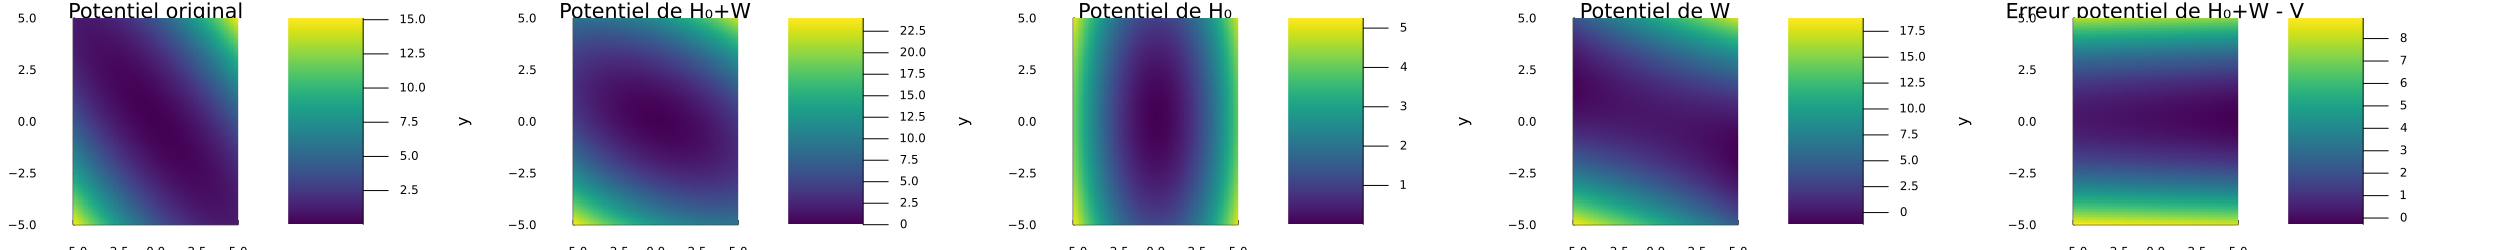

In [21]:
@time H, V, Œõ, H‚ÇÄ, V‚ÇÄ, W, V‚Çö, kx, ky, ‚àÇ¬≤yyV_at_x‚ÇÄy‚ÇÄ, lowest_energies_y, ind_y‚ÇÄ, y‚ÇÄ, ind_x‚ÇÄ, x‚ÇÄ, Œîx, Œîy, ‚àÇVy =  decompose_hamiltonian(xmin, xmax, ymin, ymax, N, V_func, m, M, ƒß, kdim);
println("kx=$(round(kx,digits=4)) \nky=$(round(ky,digits=4))\nx‚ÇÄ=$(round(x‚ÇÄ,digits=4))\ny‚ÇÄ=$(round(y‚ÇÄ,digits=4))")

plot_V  = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel original")
plot_V‚ÇÄ = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V‚ÇÄ', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel de H‚ÇÄ")
plot_V‚Çö = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V‚Çö', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel de W")
plot_V_approx = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V‚ÇÄ'+V‚Çö', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel de H‚ÇÄ+W")
plot_erreur   = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V‚ÇÄ'+V‚Çö' - V', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Erreur potentiel de H‚ÇÄ+W - V")
plot(plot_V, plot_V_approx, plot_V‚ÇÄ, plot_V‚Çö, plot_erreur, layout = (1, 5), legend = false, size=(2500,250))

#### D√©buggage

```H_test, Œõ_test, V_test =  hamiltonian_2D(xmin, xmax, ymin, ymax, Œîx, Œîx^2, Œîy, Œîy^2, N, N^2, V‚ÇÄ, m, M, ƒß);
norm(H_test- H‚ÇÄ), norm(V‚ÇÄ-reshape(V_test*ones(N*N),N,N)), norm(Œõ_test - Œõ)

H_test == Œõ_test + V_test
Œõ == Œõ_test, reshape(V_test*ones(N*N),N,N) == V‚ÇÄ

ys = ymin:Œîy:ymax;
xs = xmin:Œîx:xmax;
plot(ys,‚àÇVy[3,:])

### 3) Calcul de quelques √©l√©ments propres (√©tats + √©nergies) pour les plus petites √©nergies du hamiltonien non perturb√© $H_0$ par une m√©thode it√©rative

In [440]:
nb_modes = 70;


œï‚ÇÄ =  rand(Float64, N*N); # pour 20 modes sur 200 points, et dimension Krylov de 200, compter environ 40 secondes
@time lEk0, lœïk0, infos = KrylovKit.eigsolve(H‚ÇÄ, œï‚ÇÄ, nb_modes, :SR, krylovdim=200); # KrylovKit semble ne trouver que des solutions s√©parables ici !!
infos

  2.940645 seconds (20.22 k allocations: 356.336 MiB, 1.16% gc time)


ConvergenceInfo: 73 converged values after 22 iterations and 1660 applications of the linear map;
norms of residuals are given by (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.212672754464047e-64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5127060538910665e-17, 1.2209554489315939e-17, 9.608240210228548e-16, 5.736990838755138e-16, 1.2173853701901483e-15, 1.639683021643374e-15, 1.0220655189148046e-15).


On affiche un mode **non d√©g√©n√©r√©** parmi les √©tats stationnaires trouv√©s avec Krylov

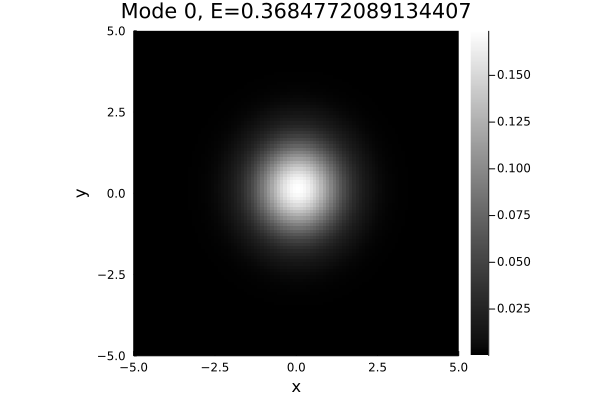

In [441]:
mode = 0;
heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), reshape(N/(xmax-xmin)*N/(ymax-ymin)*abs.(lœïk0[mode+1]).^2,N,N)' , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode $(mode), E=$(lEk0[mode+1])")

### 4) Calcul de la correction au premier de cet √©tat non d√©g√©n√©r√© avec la perturbation $W$

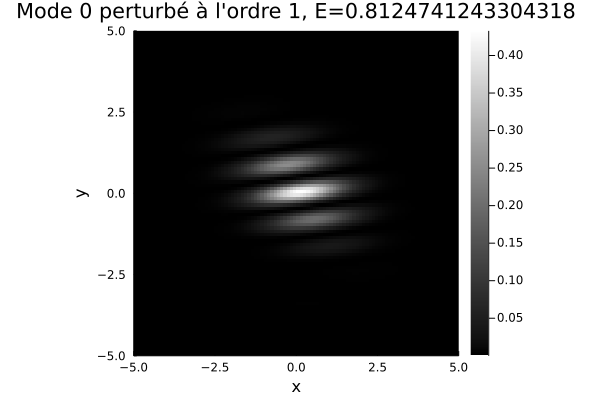

In [442]:
function correction_nd_o1(lœïk0,lEk0,mode,nb_modes,N)
    œï‚Çô = copy(lœïk0[mode+1]); # copie du vecteur initial
    E‚Çô‚Å∞ = copy(lEk0[mode+1]); # son √©nergie

    # correction √† l'√©nergie
    E‚Çô = E‚Çô‚Å∞ + œï‚Çô'*W*œï‚Çô;
    # correction au vecteur propre
    for i=1:nb_modes
        @views œï‚Çô += i==mode+1 ? zeros(N*N) : lœïk0[i]'*W*œï‚Çô/(E‚Çô‚Å∞-lEk0[i]) * lœïk0[i] # formule B-11 du Cohen-Tanoudji, chapitre 11, page 1127
    end
    œï‚Çô = œï‚Çô/norm(œï‚Çô);
    return E‚Çô,œï‚Çô
end

E‚Çô,œï‚Çô = correction_nd_o1(lœïk0,lEk0,mode,nb_modes,N);
heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), reshape(N/(xmax-xmin)*N/(ymax-ymin)*abs.(œï‚Çô).^2,N,N)' , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax), color=:greys, aspect_ratio=:equal ,title = "Mode $(mode) perturb√© √† l'ordre 1, E=$(E‚Çô)")

### 5) Calcul de l'√©tat correspondant avec le hamiltonien complet pour comparaison

In [443]:
œï =  rand(Float64, N*N); # pour 20 modes sur 200 points, et dimension Krylov de 200, compter environ 40 secondes
nb_modes = 50;
@time lE, lœïk, infos = KrylovKit.eigsolve(H, œï, nb_modes, :SR, krylovdim=200); # KrylovKit semble ne trouver que des solutions s√©parables ici !!
infos

  2.297869 seconds (14.63 k allocations: 258.969 MiB, 1.69% gc time)


ConvergenceInfo: 51 converged values after 16 iterations and 1302 applications of the linear map;
norms of residuals are given by (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.078705670004142e-31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3405892411382598e-18, 3.285192535577162e-17, 3.576214208131597e-16, 4.938518079168469e-16, 2.0856121709340882e-15, 1.7013762614589792e-13, 1.495807501785573e-14, 5.119374422266877e-13).


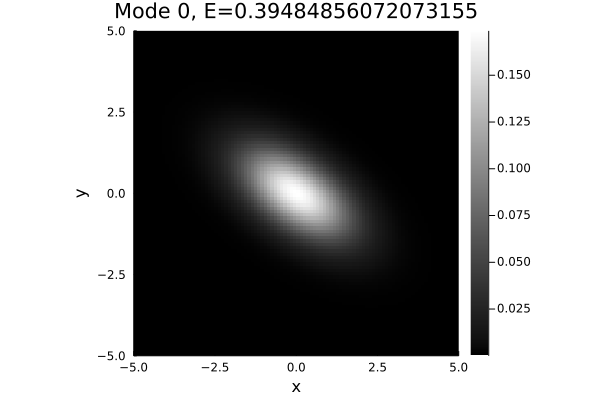

In [444]:
heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), reshape(N/(xmax-xmin)*N/(ymax-ymin)*abs.(lœïk[mode+1]).^2,N,N)' , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode $(mode), E=$(lE[mode+1])")

# Brouillon

In [ ]:
using Polynomials, SpecialPolynomials
const SP=SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [basis(Hermite, i)(x) for i in 0:20] # /!\ au d√©calage d'incice
œï1D = (n,x) -> (m*œâ/ƒß)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*œÄ^(-1/4)*H[n+1](sqrt(m*œâ/ƒß)*x)*exp(-m*œâ/2/ƒß*x^2)
œï2D = (n‚Çñ, n‚Çó, x, y) -> sqrt(m*œâ/ƒß)/sqrt(2^(n‚Çñ+n‚Çó))/sqrt(factorial(n‚Çñ)*factorial(n‚Çó))/sqrt(œÄ) * H[n‚Çñ+1](sqrt(m*œâ/ƒß)*x) * H[n‚Çó+1](sqrt(m*œâ/ƒß)*y) * exp(-m*œâ/2/ƒß*(x^2+y^2))

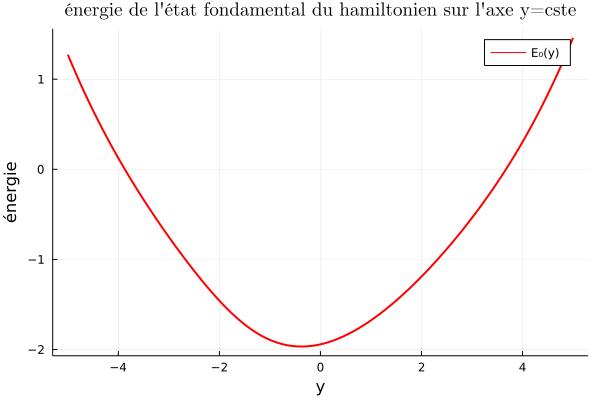

In [100]:
plot(LinRange(ymin,ymax,N), lowest_energies_y, grid=true, w=2, color = "red", linestyle=:solid, label="E‚ÇÄ(y)",
title="√©nergie de l'√©tat fondamental du hamiltonien sur l'axe y=cste", titlefont=font(12,"Computer Modern"),
xlabel="y",
ylabel="√©nergie")

  0.011517 seconds (11 allocations: 386.891 KiB)
  0.014550 seconds (14 allocations: 1011.891 KiB)


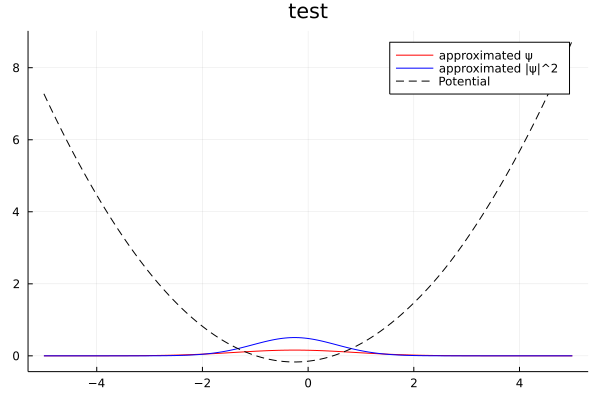

In [246]:
using Plots
using LaTeXStrings

N=200;
xmin = -5; xmax = 5;
Œîx = (xmax-xmin)/N;

Œõ = 1/Œîx^2*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
V = V_func.(LinRange(xmin,xmax,N),y‚ÇÄ);
ùí± = sparse(Diagonal(V));
H = Matrix(-ƒß^2/2/m*Œõ+ùí±);


@time vap = eigvals(H);
@time vep = eigvecs(H); # ils sont norm√©s

n‚Çì = 0; # nomrbe quantique
axis_range = LinRange(xmin,xmax,N);
plot(axis_range, [vep[:,n‚Çì+1], N/(xmax-xmin)*abs.(vep[:,n‚Çì+1]).^2, V], grid=true, w=[1 1 1], color = ["red" "blue" "black"], linestyle=[:solid :solid :dash], label=["approximated œà" "approximated |œà|^2" "Potential"], title = "test")

In [151]:
data = [1 20 30; 20 1 60; 30 60 1]

3√ó3 Matrix{Int64}:
  1  20  30
 20   1  60
 30  60   1